In [1]:
from preprocess.preprocess import *
import PARAMETERS
PARAMETERS.DATASET = 'DRIVE'

import pandas as pd
import numpy as np

In [2]:
preprocess = Preprocess(height=608, width=576)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:14]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)

n_pixels

{0: 225600,
 1: 227686,
 2: 228187,
 3: 227726,
 4: 227362,
 5: 225092,
 6: 227826,
 7: 227327,
 8: 227309,
 9: 227259,
 10: 227701,
 11: 224944,
 12: 227738,
 13: 226542}

In [3]:
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

pixel_ref

{0: (0, 225600),
 1: (225600, 453286),
 2: (453286, 681473),
 3: (681473, 909199),
 4: (909199, 1136561),
 5: (1136561, 1361653),
 6: (1361653, 1589479),
 7: (1589479, 1816806),
 8: (1816806, 2044115),
 9: (2044115, 2271374),
 10: (2271374, 2499075),
 11: (2499075, 2724019),
 12: (2724019, 2951757),
 13: (2951757, 3178299)}

In [4]:
cv_folds = {}

for i, j in enumerate(range(0, 14, 3)):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+2, 13)][1])
    
cv_folds

{0: (0, 681473),
 1: (681473, 1361653),
 2: (1361653, 2044115),
 3: (2044115, 2724019),
 4: (2724019, 3178299)}

In [5]:
PARAMETERS.LBP_METHOD = 'riu2'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 1
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = False
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False

df_train = pd.DataFrame()
df_test = pd.DataFrame()
for r in range(2, 5):
    db_path = f'../DB/{PARAMETERS.DATASET}/extra_features/radius/{r}'
    for filename in Path(db_path).glob('train_train_*'):   
        file_extension = \
            str(filename).replace('train_train_', '').split('/')[-1].replace('.pkl', '')
        properties = file_extension.replace(
            'get_pyramid_dataset', 'get-pyramid-dataset').replace(
            'get_datasets_by_scale', 'get-dataset-by-scale').split('_')
        lbp_method = properties[0]
        df_train_temp = pd.read_pickle(filename, compression='gzip')
        df_test_temp = pd.read_pickle(str(filename).replace('train_train', 'train_test'), compression='gzip')
        df_train_temp = df_train_temp.drop(['Original', 'label'], axis=1)
        df_test_temp = df_test_temp.drop(['Original', 'label'], axis=1)
        df_train_temp.columns = [f'1:1_{lbp_method}_{r}']
        df_test_temp.columns = [f'1:1_{lbp_method}_{r}']
        df_train = pd.concat([df_train, df_train_temp], axis=1)
        df_test = pd.concat([df_test, df_test_temp], axis=1)

PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False

def get_convolution_features(seed=0):
    #np.random.seed(seed)
    #kernel_list = [np.round(np.random.uniform(low=-1, high=1, size=(9,)).reshape(3, 3), 3) for _ in range(5)]
    #kernel_list += [np.round(np.random.uniform(low=-1, high=1, size=(25,)).reshape(5, 5), 3) for _ in range(5)]

    kernel_list = []
    # https://dsp.stackexchange.com/questions/44928/what-does-derivative-means-in-image-processing/44930
    # LAPLACIAN
    kernel_list.append(np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]))
    kernel_list.append(np.array([[-1, 2, -1], [2, -8, 2], [-1, 2, -1]]))

    # https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d
    # SCHARR
    kernel_list.append(np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]))
    kernel_list.append(np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]]))

    # https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
    # SOBEL
    kernel_list.append(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
    kernel_list.append(np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]))

    paths = []
    for kernel in kernel_list:
        PARAMETERS.CONVOLUTION = kernel
        PARAMETERS.CONV_PATH = PARAMETERS.update_convolution_path(PARAMETERS)
        paths.append(f"../DB/{PARAMETERS.DATASET}/extra_features/convolution/{PARAMETERS.CONV_PATH}")


    for i, path in enumerate(paths):
        train_path = list(Path(path).glob('train_train*'))[0]
        test_path = list(Path(path).glob('train_test*'))[0]
        if i == 0:
            df_train_convolutions = pd.read_pickle(train_path, compression='gzip')
            df_train_convolutions.drop(['label'], axis=1, inplace=True)
            df_train_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_train_convolutions.columns]
            df_test_convolutions = pd.read_pickle(test_path, compression='gzip')
            df_test_convolutions.drop(['label'], axis=1, inplace=True)
            df_test_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_test_convolutions.columns]
        else:
            df_temp = pd.read_pickle(train_path, compression='gzip')
            df_temp.drop(['label'], axis=1, inplace=True)
            df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
            df_train_convolutions = pd.concat([df_train_convolutions, df_temp], axis=1)
            df_temp = pd.read_pickle(test_path, compression='gzip')
            df_temp.drop(['label'], axis=1, inplace=True)
            df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
            df_test_convolutions = pd.concat([df_test_convolutions, df_temp], axis=1)
    return df_train_convolutions, df_test_convolutions

df_train_convolutions, df_test_convolutions = get_convolution_features(seed=0)

df_train_extra_features = pd.concat([df_train, df_train_convolutions], axis=1)
df_test_extra_features = pd.concat([df_test, df_test_convolutions], axis=1)

In [6]:
from main import load_datasets_for_lbp_operator, get_channel_features

parent_path = '../'
for i, lbp_operator in enumerate(['default', 'riu', 'riu2', 'nriuniform', 'var']):
    PARAMETERS.LBP_METHOD = lbp_operator
    PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
    if i == 0:
        df_train, df_test, y_train, y_test = load_datasets_for_lbp_operator(parent_path)
    else:
        temp_datasets = load_datasets_for_lbp_operator(parent_path, discard_columns=True)
        df_train = pd.concat([df_train, temp_datasets[0]], axis=1)
        df_test = pd.concat([df_test, temp_datasets[1]], axis=1)
        
df_train_channels, df_test_channels = get_channel_features(parent_path)
df_train = pd.concat([df_train, df_train_channels], axis=1)
df_test = pd.concat([df_test, df_test_channels], axis=1)

In [7]:
df_train = pd.concat([df_train, df_train_extra_features], axis=1)
df_test = pd.concat([df_test, df_test_extra_features], axis=1)

In [8]:
df_train

,Original,default_1:1,default_1:2,default_1:4,default_1:8,default_2:1_1,default_2:1_2,default_2:1_3,default_2:1_4,riu_1:1,...,2:1_4_-1;0;1;-2;0;2;-1;0;1,Original_-1;-2;-1;0;0;0;1;2;1,1:1_-1;-2;-1;0;0;0;1;2;1,1:2_-1;-2;-1;0;0;0;1;2;1,1:4_-1;-2;-1;0;0;0;1;2;1,1:8_-1;-2;-1;0;0;0;1;2;1,2:1_1_-1;-2;-1;0;0;0;1;2;1,2:1_2_-1;-2;-1;0;0;0;1;2;1,2:1_3_-1;-2;-1;0;0;0;1;2;1,2:1_4_-1;-2;-1;0;0;0;1;2;1
0,1,225,225,225,225,193,192,227,225,8,...,56.0,-0.0,207.0,241.0,255.0,255.0,3.0,193.0,255.0,1.0
1,1,225,225,225,225,240,241,224,241,8,...,227.0,-0.0,255.0,241.0,255.0,255.0,96.0,17.0,0.0,255.0
2,1,225,225,225,225,225,241,225,225,8,...,241.0,-0.0,255.0,241.0,255.0,255.0,1.0,0.0,239.0,239.0
3,1,225,225,225,225,225,241,225,225,8,...,112.0,-0.0,255.0,241.0,255.0,255.0,255.0,239.0,233.0,225.0
4,1,225,225,225,225,224,241,225,224,8,...,255.0,-0.0,255.0,241.0,255.0,255.0,239.0,238.0,225.0,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226537,1,30,14,31,30,30,30,30,30,8,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
226538,1,30,14,31,30,30,31,31,31,8,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
226539,1,30,30,31,30,30,30,30,30,8,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
226540,1,30,30,31,30,30,30,30,30,8,...,255.0,-0.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [9]:
from main import init_clf_and_fit

y_train = y_train.to_frame()
for k, v in cv_folds.items():
    PARAMETERS.MODEL_NAME = f"_cv_{k}"
    df_train_temp = pd.concat([df_train.iloc[cv_folds[0][0]:v[0], :], df_train.iloc[v[1]:cv_folds[4][1], :]], axis=0)
    y_train_temp = pd.concat([y_train.iloc[cv_folds[0][0]:v[0], :], y_train.iloc[v[1]:cv_folds[4][1], :]], axis=0)
    clf = init_clf_and_fit(df_train_temp, y_train_temp.values.ravel(), lgb='Num', parent_path='../models')
    #y_predicted = clf.predict(df_train.iloc[v[0]:v[1], :])

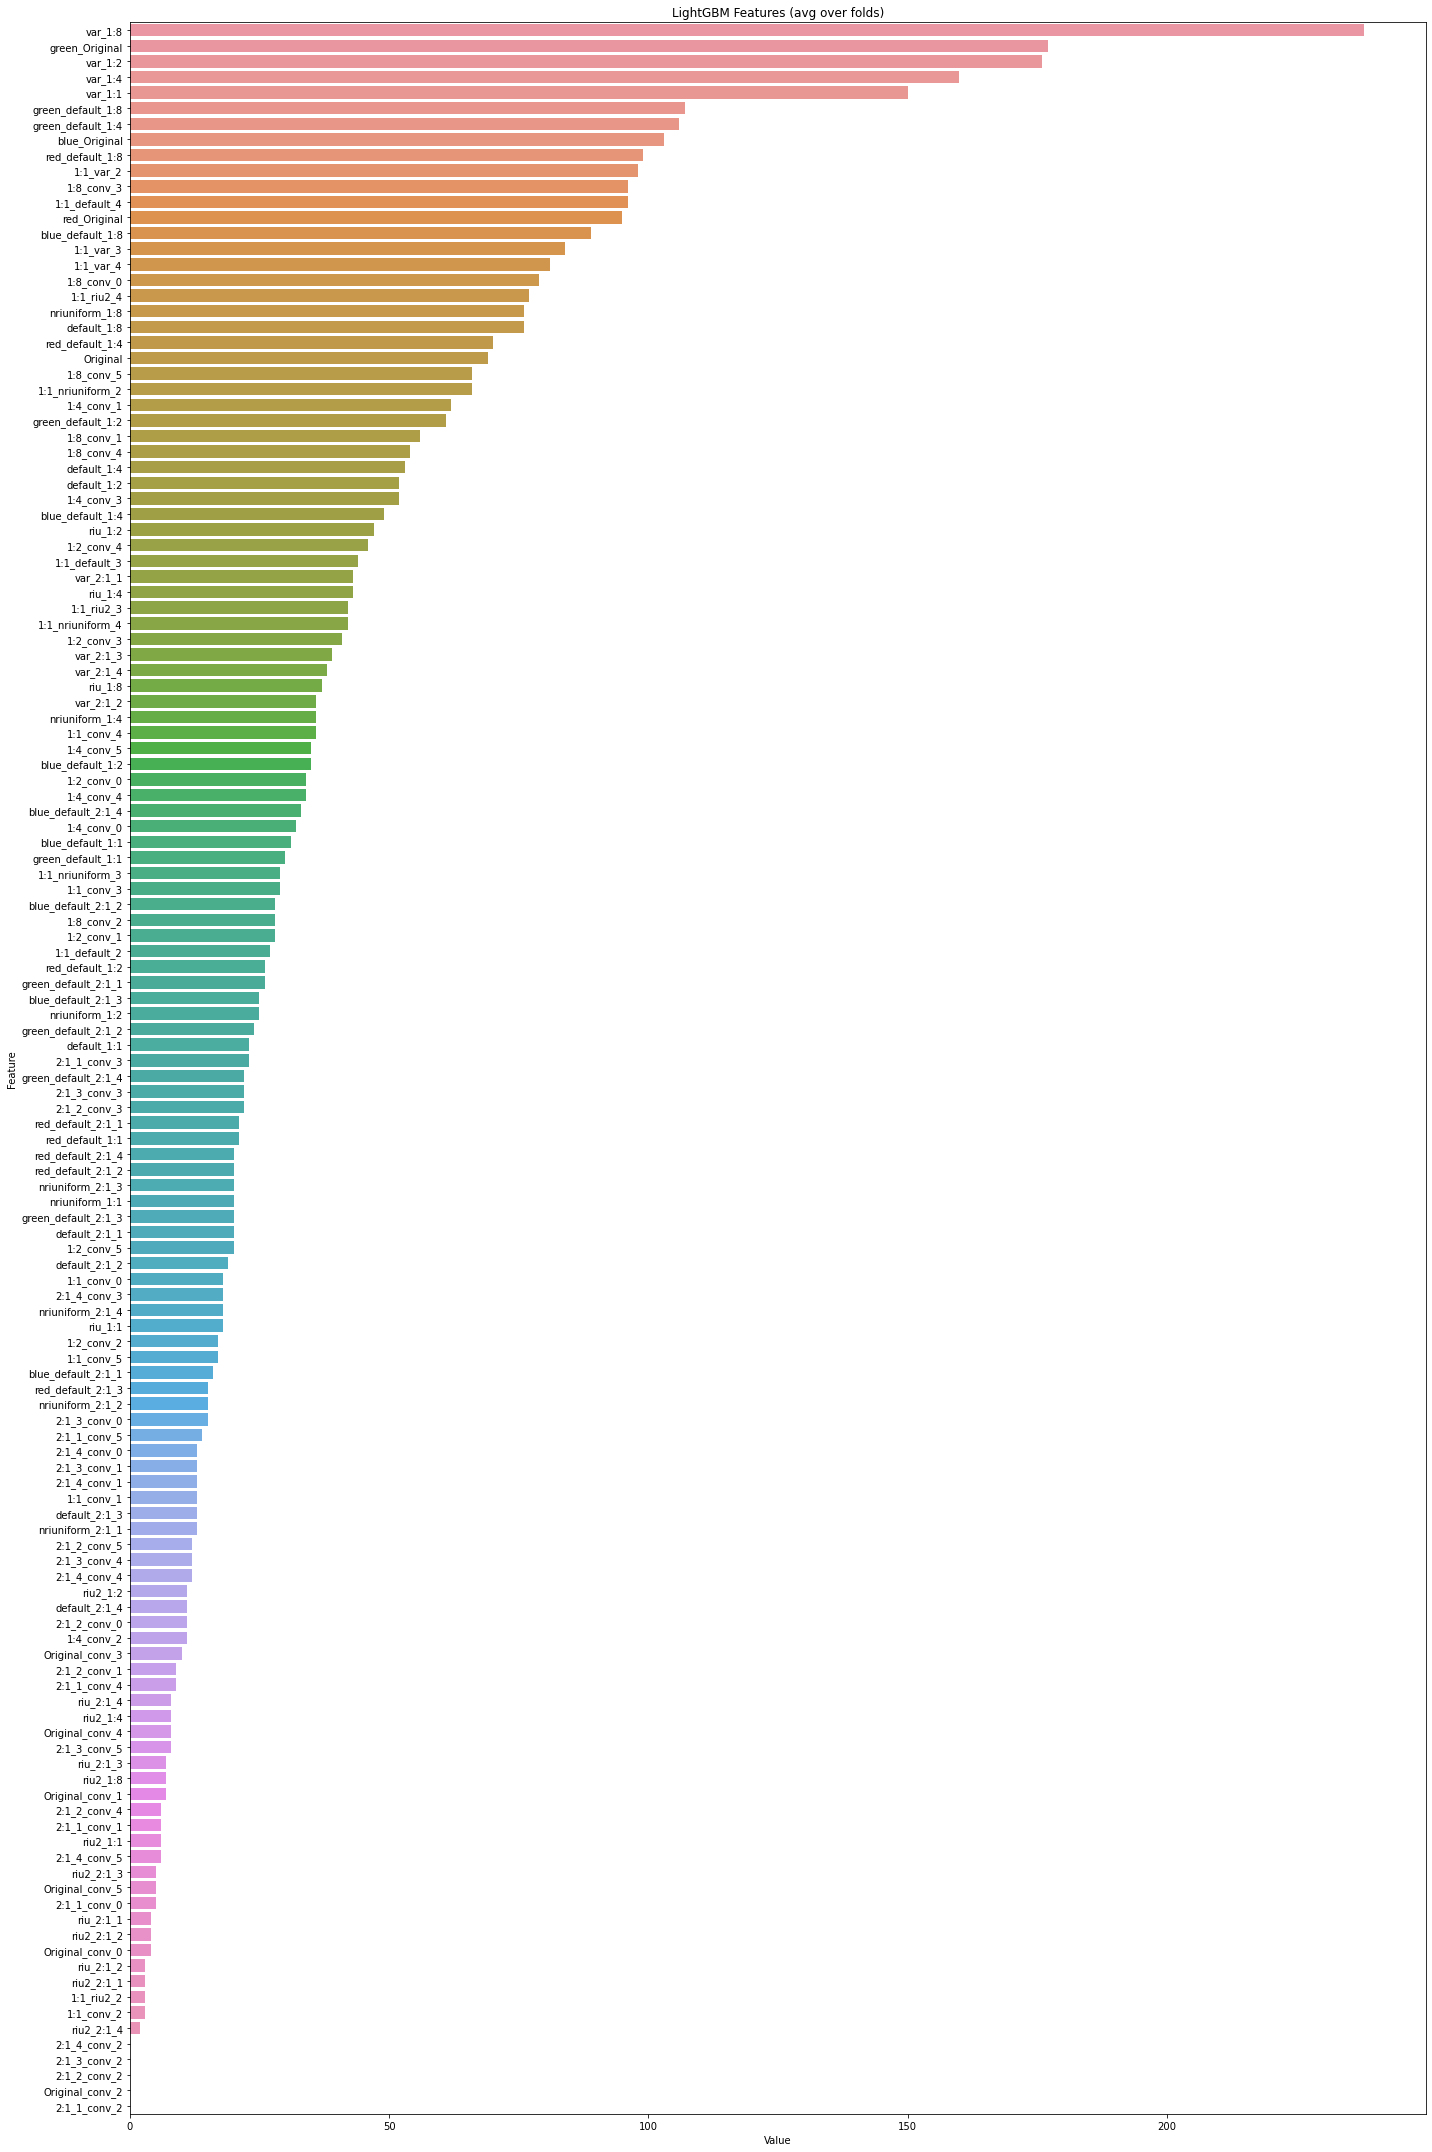

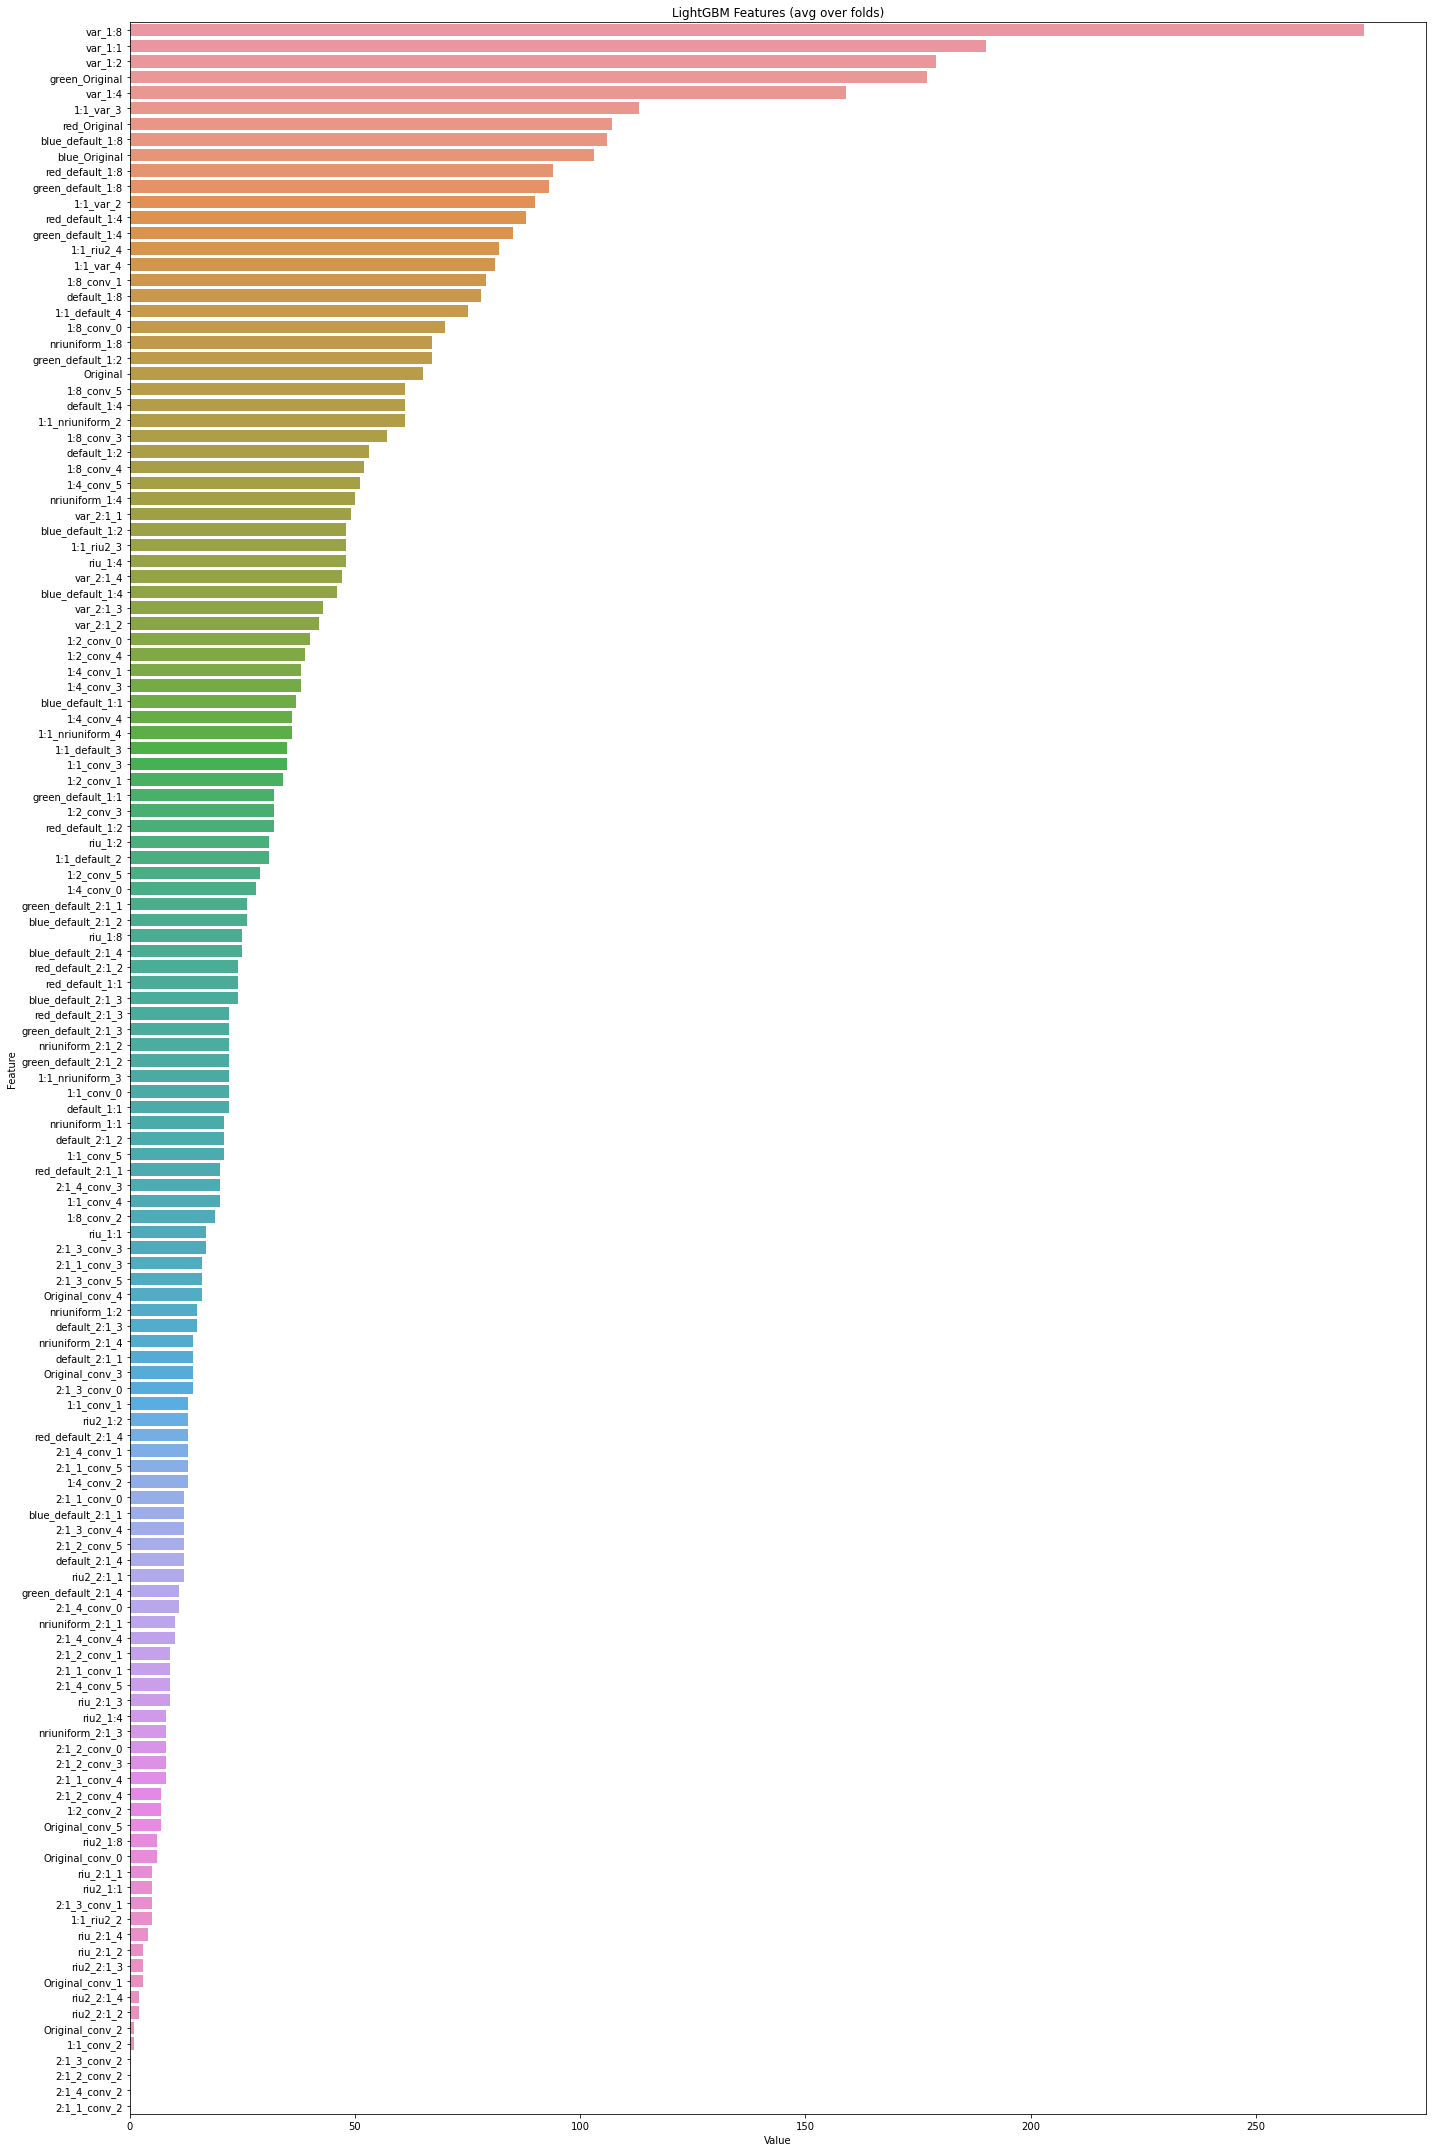

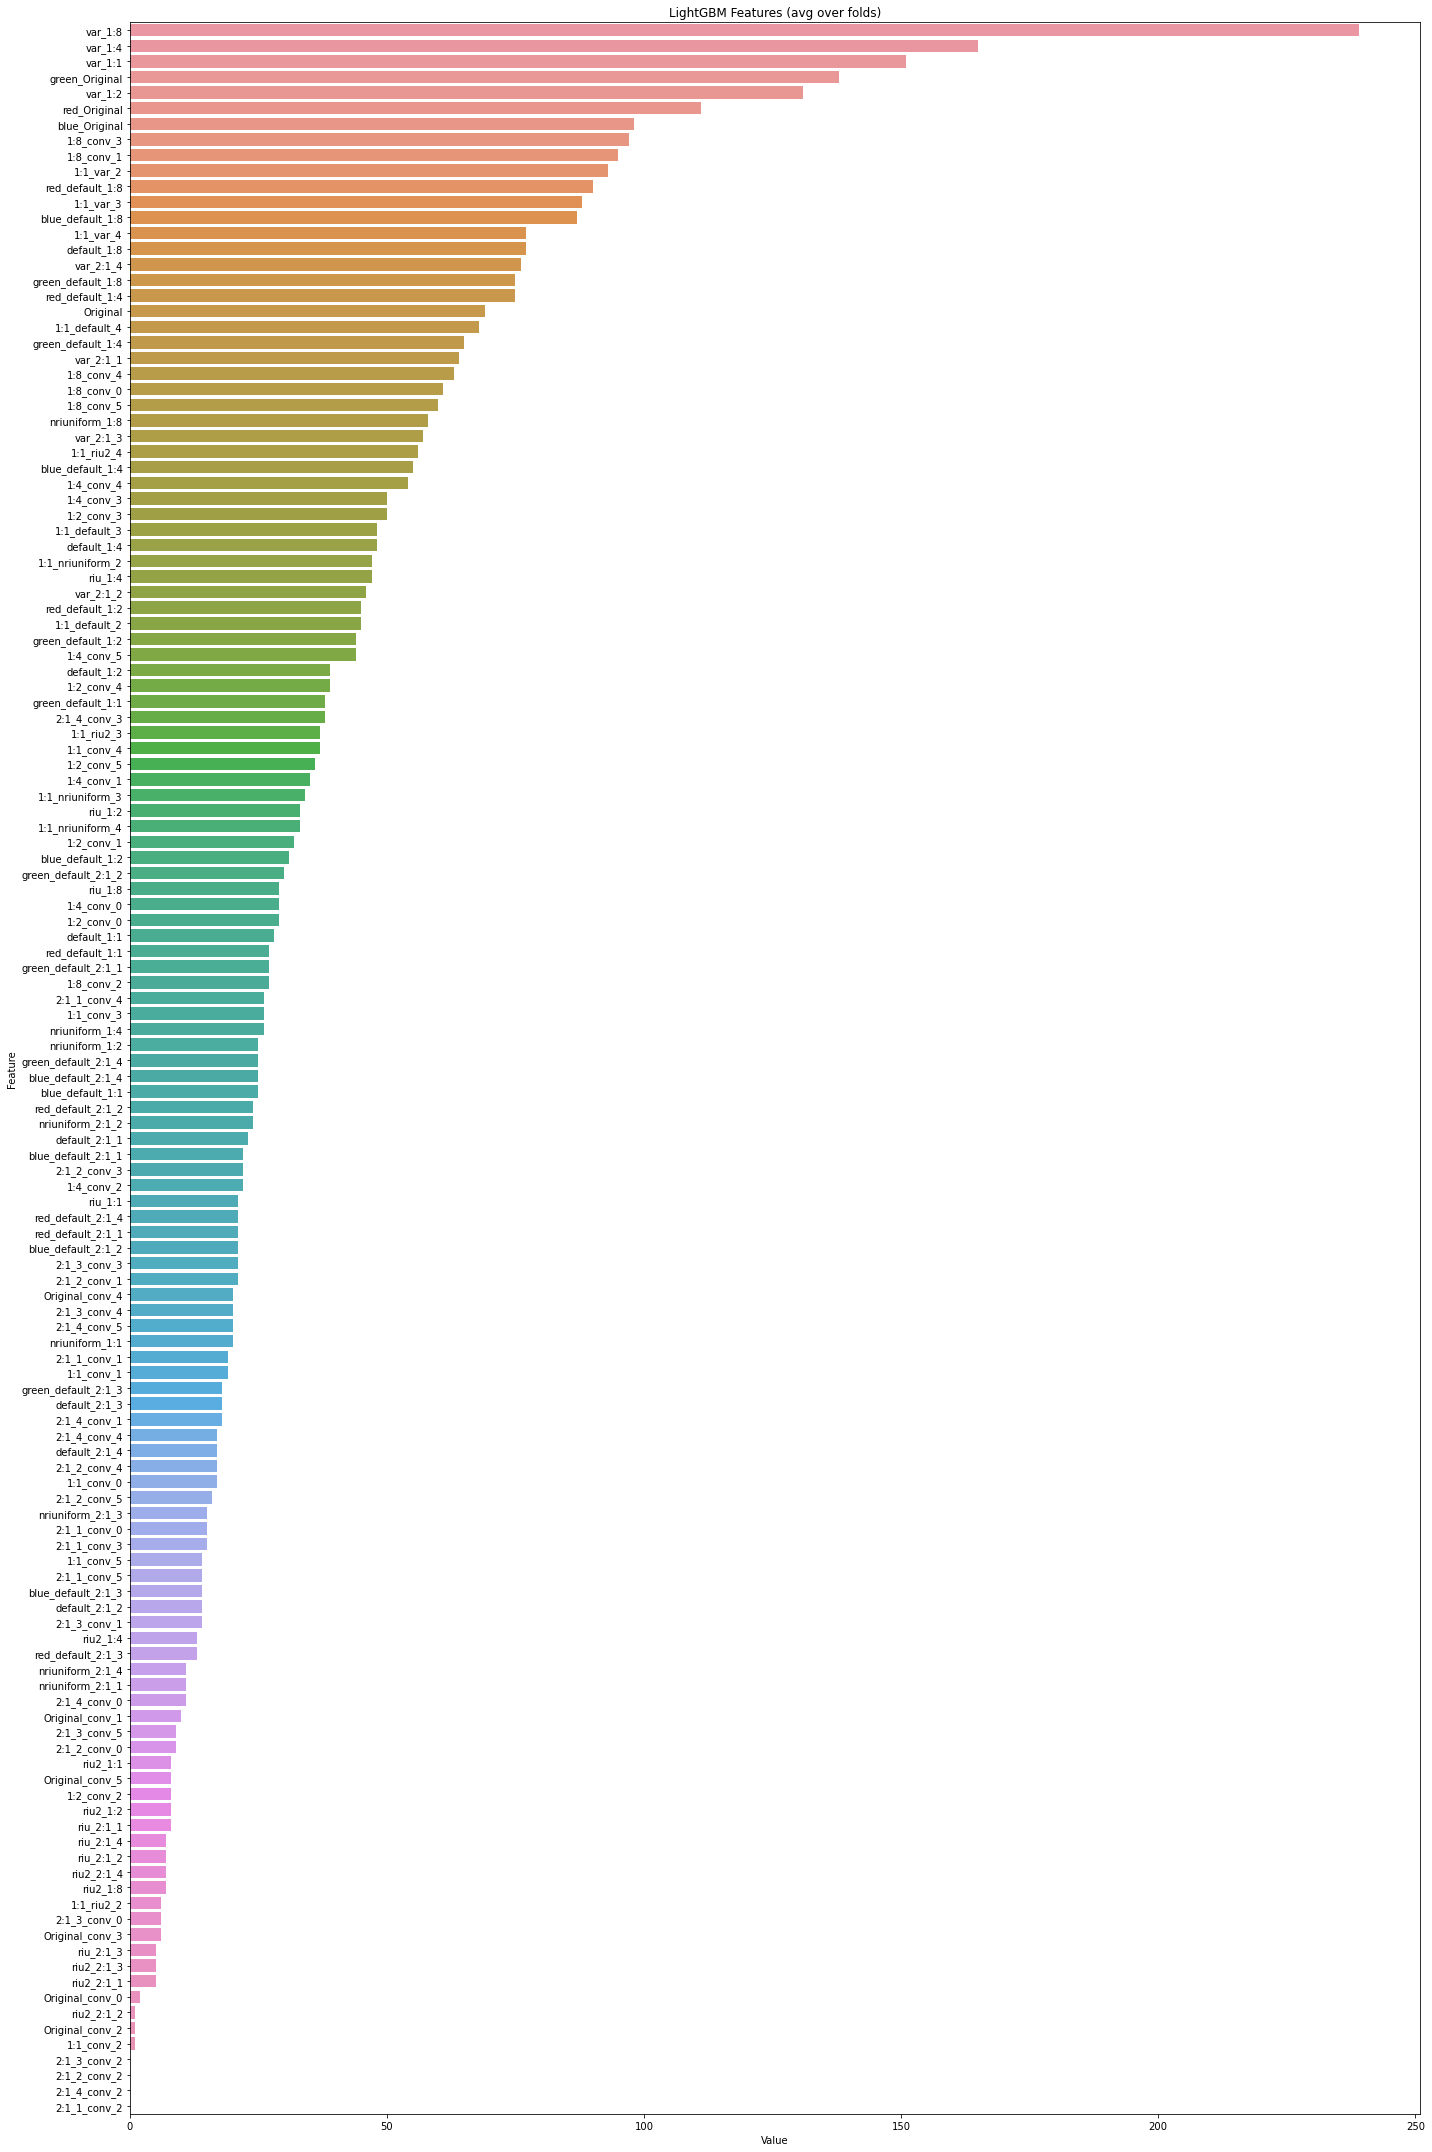

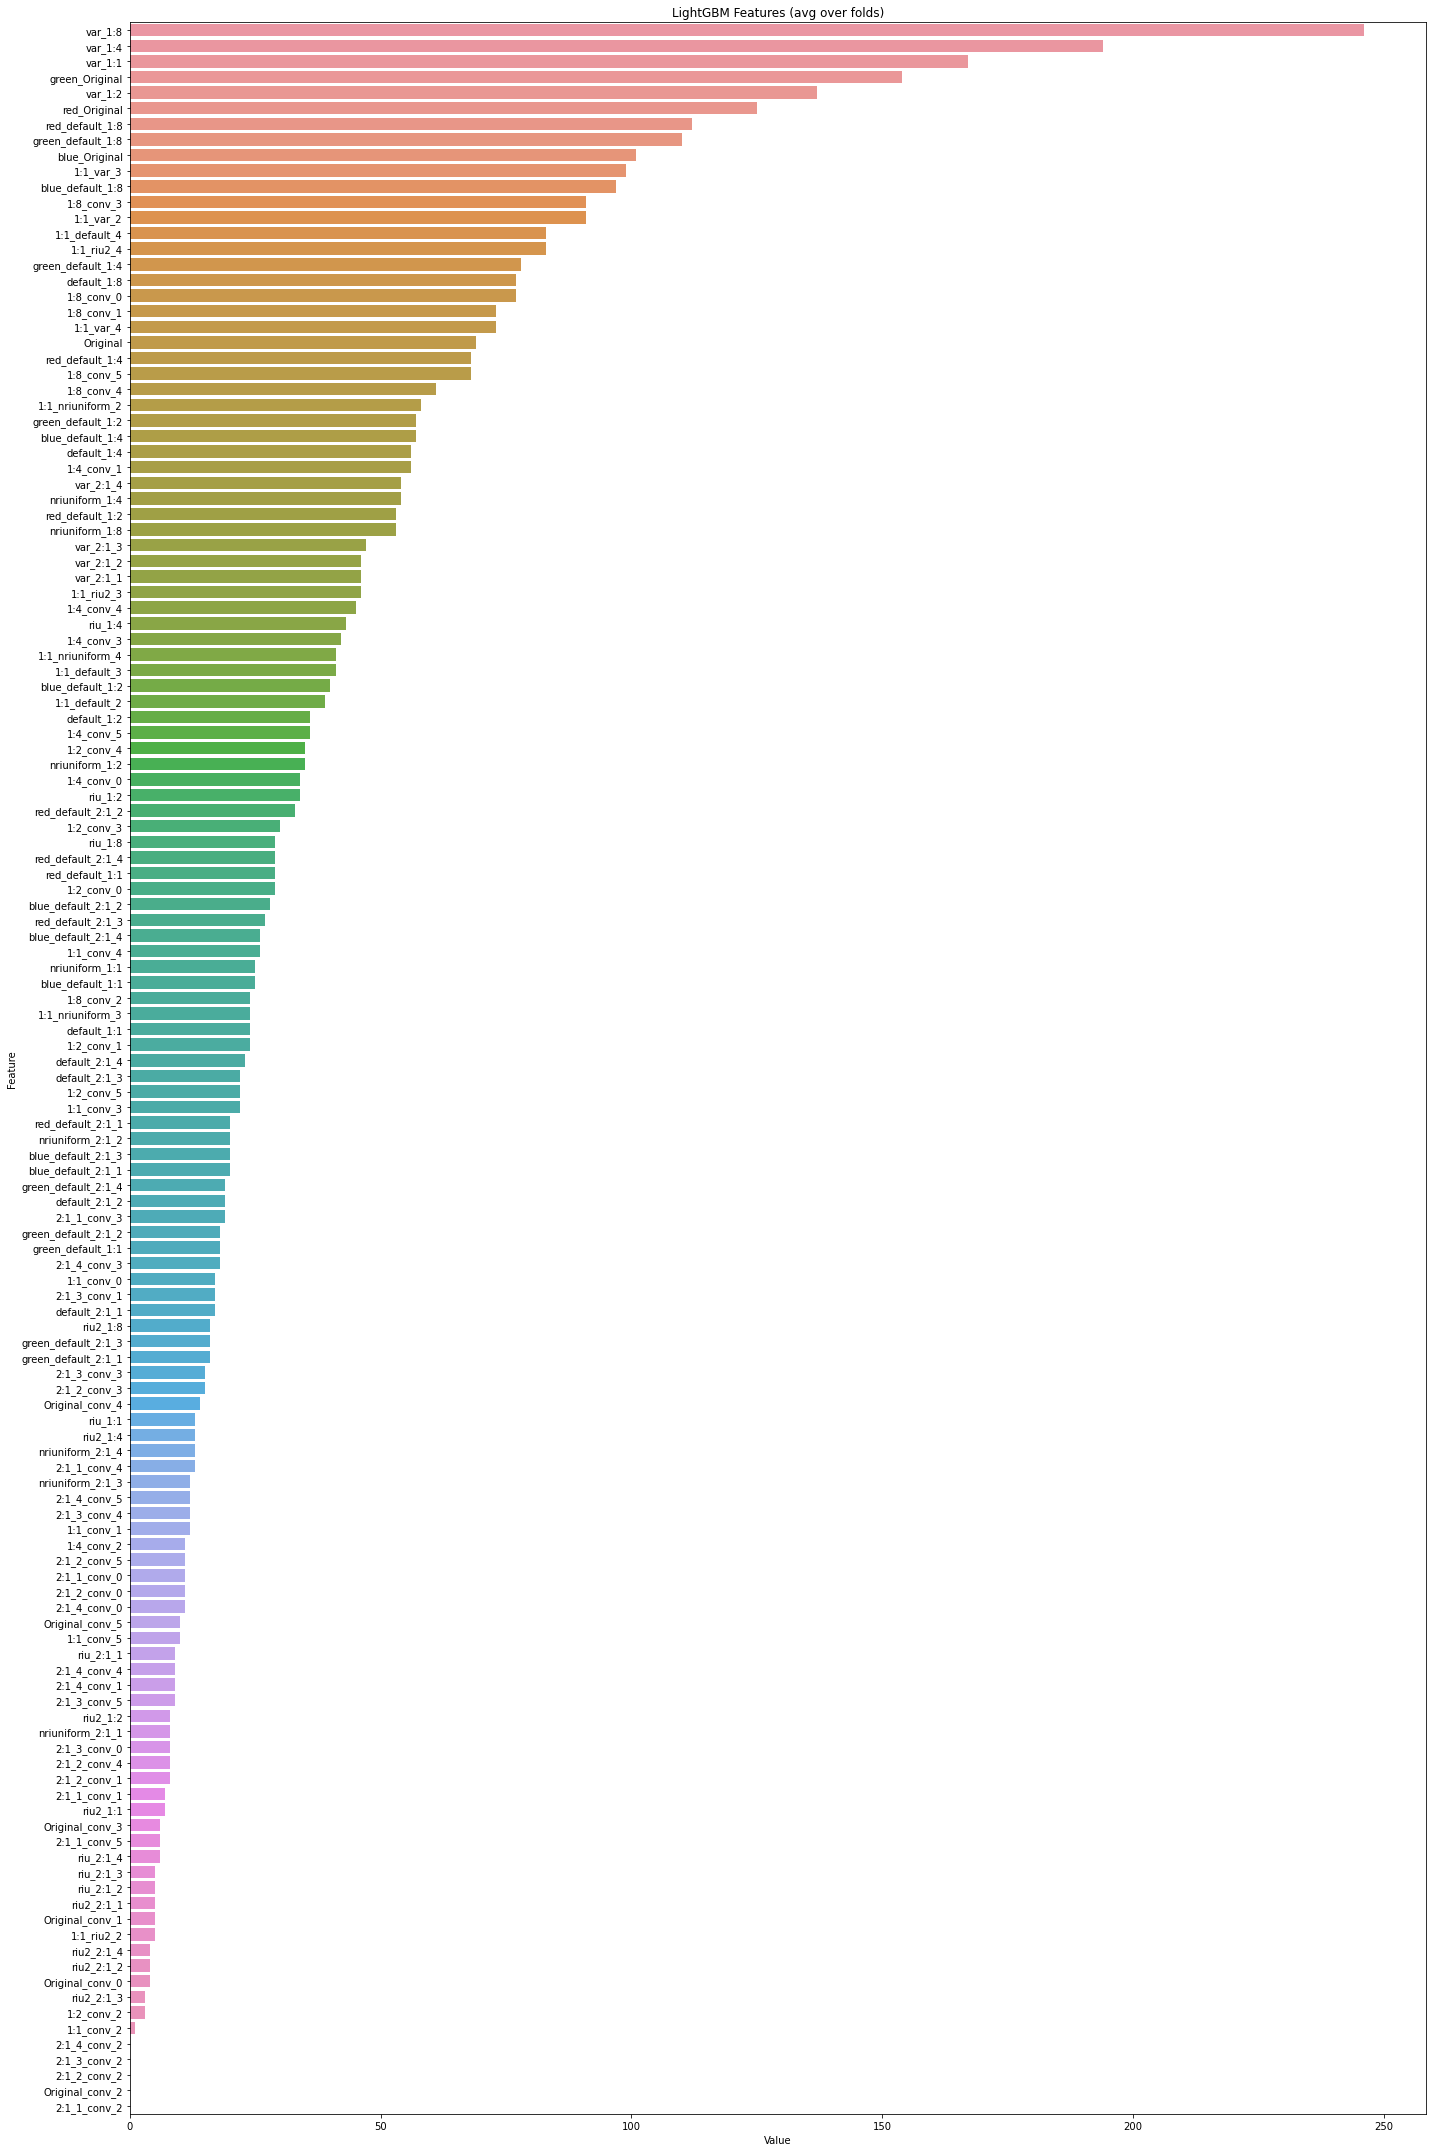

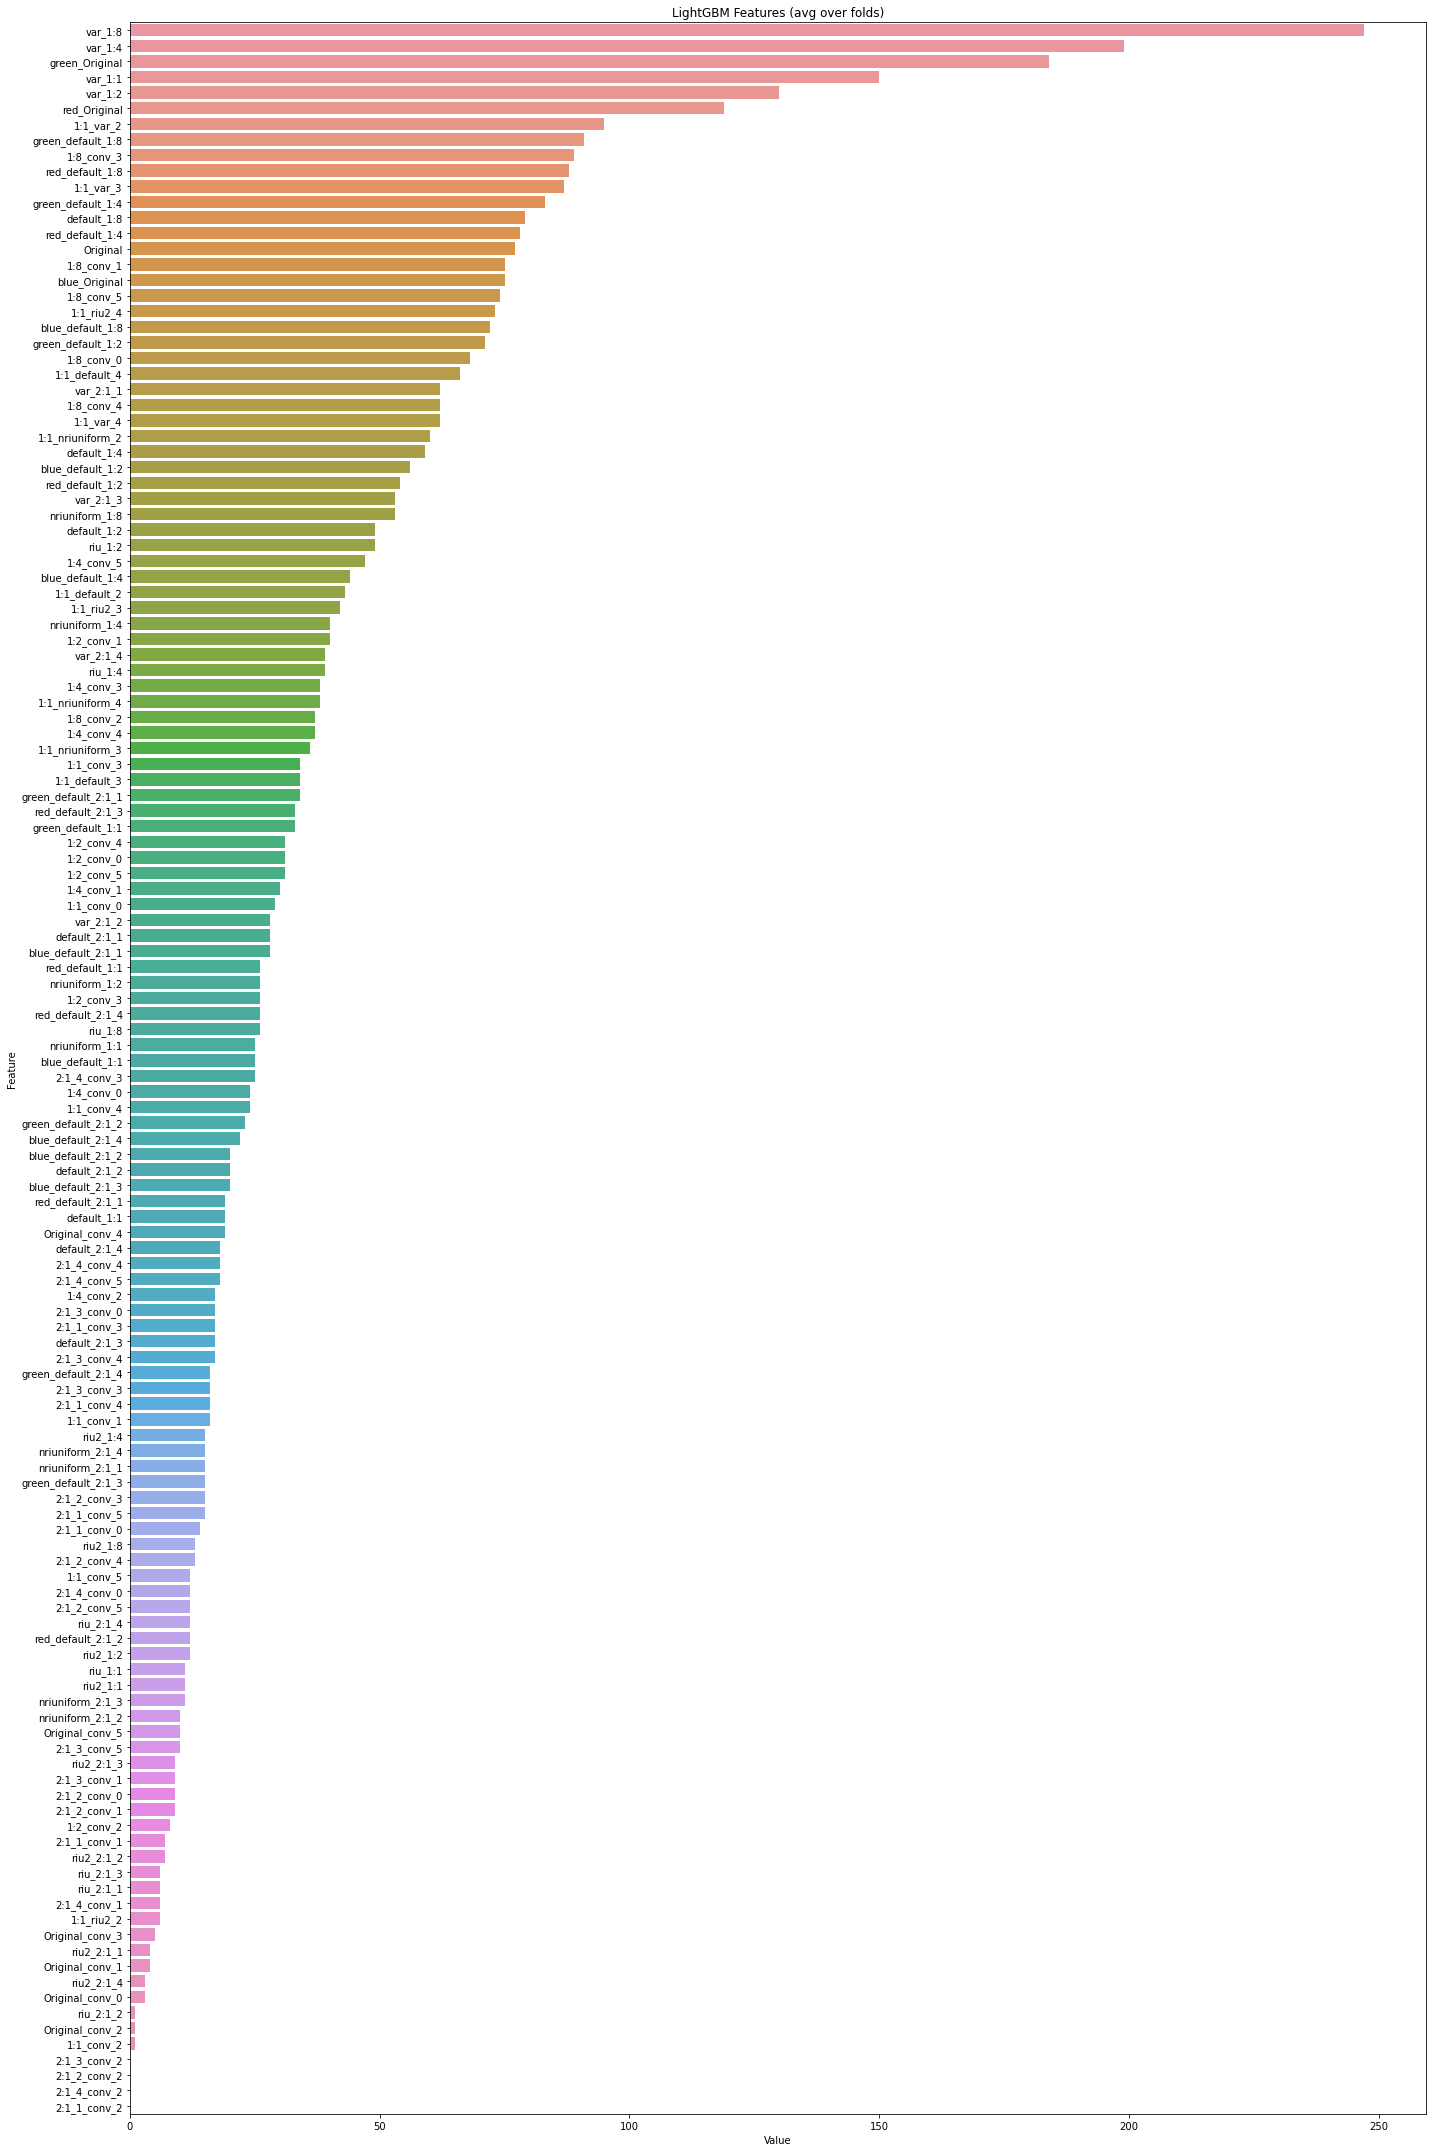

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = {}
for i in range(5):
    with open(f"../models/lbm_fit_cv_{i}.pkl", 'rb') as f:
        model = pickle.load(f)
    feature_imp[i] = pd.DataFrame(sorted(zip(model['clf'].feature_importances_, model['features'])), columns=['Value','Feature'])
    convolutions = list(set([c.split('_')[-1] for c in feature_imp[i]['Feature'] if ';' in c]))
    convolutions = {c: f'conv_{i}' for i, c in enumerate(convolutions)}
    feature_imp[i]['Feature'] = [c if ';' not in c else c.replace(c.split('_')[-1], convolutions[c.split('_')[-1]]) for c in feature_imp[i]['Feature']]


    plt.figure(figsize=(20, 30))
    sns.barplot(x="Value", y="Feature", data=feature_imp[i].sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [11]:
df_feature_imp = feature_imp[0].sort_values(by="Feature")
for i, df in enumerate(feature_imp.values()):
    if i > 0:
        df_feature_imp['Value'] += df.sort_values(by="Feature")["Value"]

In [12]:
df_feature_imp = df_feature_imp.sort_values(by="Value", ascending=False)
df_feature_imp

,Value,Feature
133,1244,var_1:8
132,925,green_Original
131,857,var_1:2
130,779,var_1:4
129,707,var_1:1
...,...,...
4,3,Original_conv_2
2,0,2:1_3_conv_2
1,0,2:1_2_conv_2
3,0,2:1_4_conv_2


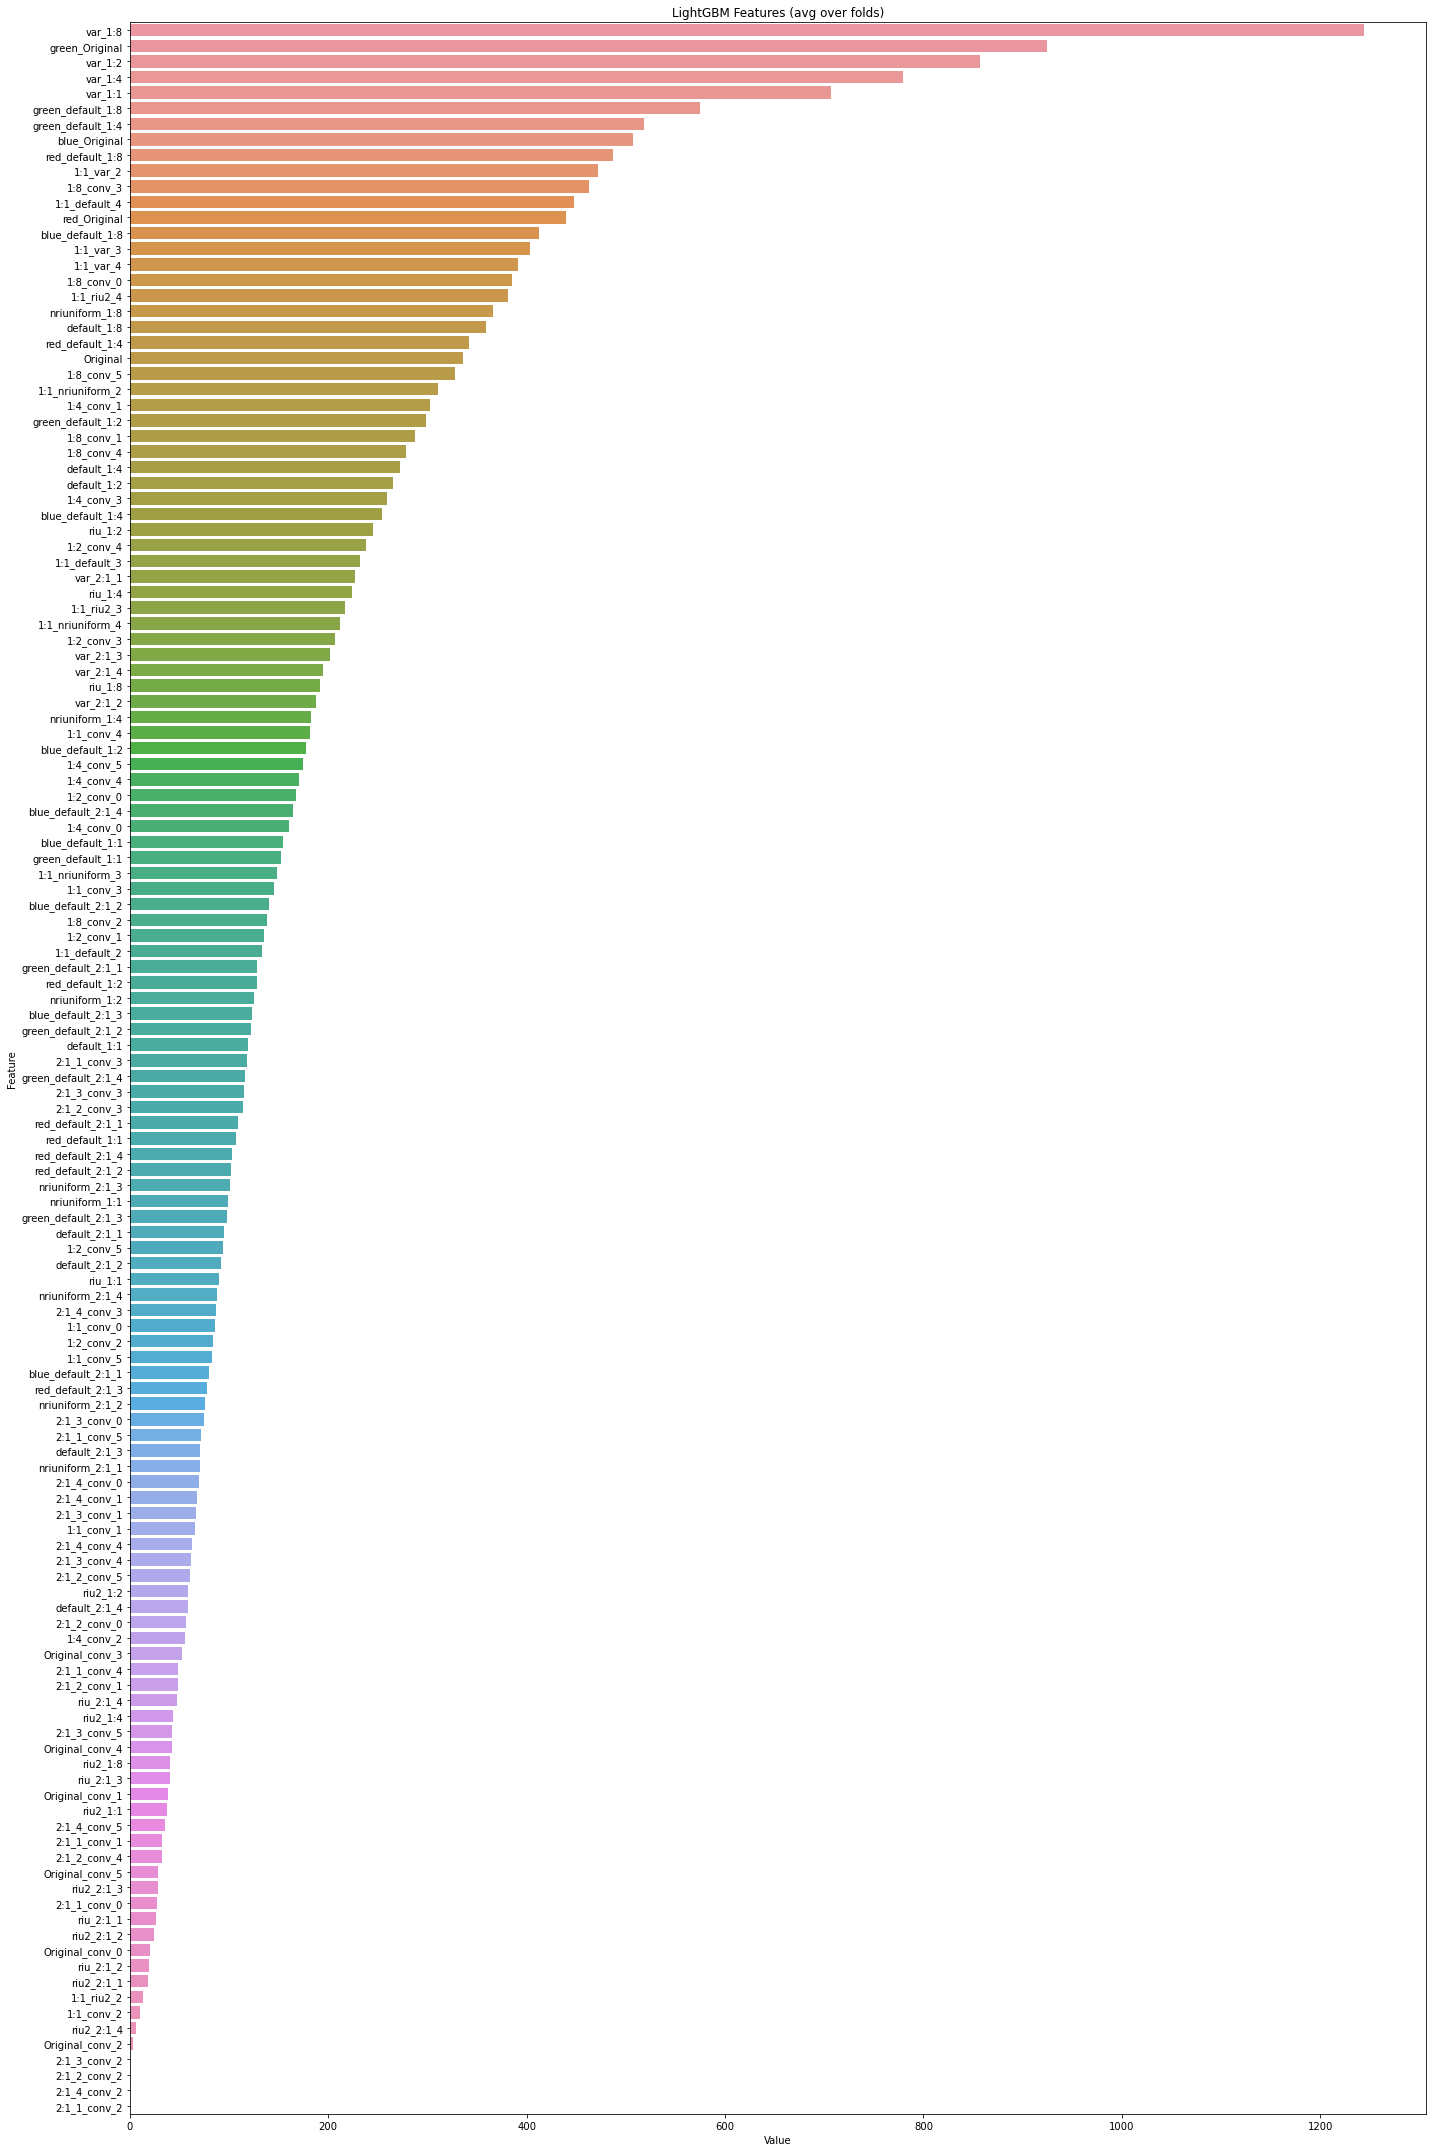

In [13]:
plt.figure(figsize=(20, 30))
sns.barplot(x="Value", y="Feature", data=df_feature_imp)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [14]:
from confusion_matrix_pretty_print import print_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def train_predict_metrics(x_train, x_test, y_train, y_test):
    clf = init_clf_and_fit(x_train, y_train, 'Num', parent_path + '/models')
    y_predicted = clf.predict(x_test)

    label_predicted = np.array(y_predicted)
    preprocess = Preprocess(height=608, width=576)
    images_path = f'{parent_path}/dataset/{PARAMETERS.DATASET}/training/images/'
    image_path = sorted(os.listdir(images_path))[14]
    masks_path = f'{parent_path}/dataset/{PARAMETERS.DATASET}/training/mask/'
    mask_path = sorted(os.listdir(masks_path))[14]
    img = preprocess.read_img(images_path + image_path).ravel()
    mask = preprocess.read_img(masks_path + mask_path)
    img = img[mask.ravel() > 100]
    preprocess.plot_preprocess_with_label(img, label_predicted[:len(img)], mask)
    label_predicted = np.delete(label_predicted, np.arange(len(img)))
    
    acc = accuracy_score(y_test, y_predicted)
    f1 = f1_score(y_test, y_predicted)
    mat = confusion_matrix(y_test, y_predicted).ravel()
    print('Accuracy score: ' + str(acc) + '\n')
    print('F1 score: ' + str(f1) + '\n')
    print('Confusion matrix:\n')
    print_confusion_matrix(y_test, y_predicted)
    print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
    print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')

In [15]:
#train_predict_metrics(df_train, df_test, y_train, y_test)
f1_list = []
acc_list = []
#if isinstance(y_test, pd.Series):
#    y_test = y_test.to_frame()
for k, v in cv_folds.items():
    with open(f"../models/lbm_fit_cv_{k}.pkl", 'rb') as f:
        model = pickle.load(f)
    y_predicted = model['clf'].predict(df_train.iloc[v[0]:v[1], :])
    acc = accuracy_score(y_train.iloc[v[0]:v[1], :], y_predicted)
    acc_list.append(acc)
    f1 = f1_score(y_train.iloc[v[0]:v[1], :], y_predicted)
    f1_list.append(f1)
    mat = confusion_matrix(y_train.iloc[v[0]:v[1], :], y_predicted).ravel()
    print('Accuracy score: ' + str(acc) + '\n')
    print('F1 score: ' + str(f1) + '\n')
    print('Confusion matrix:\n')
    print_confusion_matrix(y_train.iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
    print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
    print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
    print('-------------------------------------')

f1_ref = np.mean(f1_list)
print('====== Mean ======')
print('Accuracy: ', np.mean(acc_list))
print('F1: ', f1_ref)

Accuracy score: 0.9435384820821955

F1 score: 0.7383851776304606

Confusion matrix:

     t/p      0     1 
        0 588697 16612 
        1 21865 54299 
Sensivity: 0.7129221154351137
Specificity: 0.9725561655286804
-------------------------------------
Accuracy score: 0.9244979270193184

F1 score: 0.6910624372108691

Confusion matrix:

     t/p      0     1 
        0 571387 11418 
        1 39937 57438 
Sensivity: 0.5898639281129653
Specificity: 0.9804085414503994
-------------------------------------
Accuracy score: 0.9381181662861815

F1 score: 0.7485861243734298

Confusion matrix:

     t/p      0     1 
        0 577357 16087 
        1 26145 62873 
Sensivity: 0.7062953559954167
Specificity: 0.9728921347254332
-------------------------------------
Accuracy score: 0.9420050477714501

F1 score: 0.7112952942985378

Confusion matrix:

     t/p      0     1 
        0 591899 15275 
        1 24156 48574 
Sensivity: 0.6678674549704386
Specificity: 0.9748424669040505
------------------

In [16]:
'''
conv_4 = list(convolutions.keys())[4]
conv_5 =  list(convolutions.keys())[5]
conv_8 =  list(convolutions.keys())[8]
conv_1 =  list(convolutions.keys())[1]
conv_6 =  list(convolutions.keys())[6]
# Remove conv_1, conv_4, conv5, conv_8, riu2, conv_6, riu, red, 1:8, 2:1
cols_to_remove = [c for c in df_train.columns if conv_6 in c or conv_1 in c or conv_4 in c or conv_5 in c or 'riu2' in c or conv_8 in c or 'riu_' in c or 'red' in c or '1:8' in c or '2:1' in c]
# Remove radius 4
#cols_to_remove += [c for c in df_train.columns if ('conv' not in c and (c.endswith('_2') or c.endswith('_2')))]
'''
# Remove riu2, riu, red, 1:8, 2:1
cols_to_remove = [c for c in df_train.columns if 'riu2' in c or 'riu_' in c or 'red' in c or '1:8' in c or '2:1' in c]


In [17]:
f1_list = []
acc_list = []
for k, v in cv_folds.items():
    PARAMETERS.MODEL_NAME = f"_cv_feat_sel_{k}"
    df_train_temp = pd.concat([df_train.iloc[cv_folds[0][0]:v[0], :], df_train.iloc[v[1]:cv_folds[4][1], :]], axis=0)
    y_train_temp = pd.concat([y_train.iloc[cv_folds[0][0]:v[0], :], y_train.iloc[v[1]:cv_folds[4][1], :]], axis=0)
    clf = init_clf_and_fit(df_train_temp.drop(columns=cols_to_remove), y_train_temp, lgb='Num', parent_path='../models')
    y_predicted = clf.predict(df_train.iloc[v[0]:v[1], :].drop(columns=cols_to_remove))
    acc = accuracy_score(y_train.iloc[v[0]:v[1], :], y_predicted)
    acc_list.append(acc)
    f1 = f1_score(y_train.iloc[v[0]:v[1], :], y_predicted)
    f1_list.append(f1)
    mat = confusion_matrix(y_train.iloc[v[0]:v[1], :], y_predicted).ravel()
    print('Accuracy score: ' + str(acc) + '\n')
    print('F1 score: ' + str(f1) + '\n')
    print('Confusion matrix:\n')
    print_confusion_matrix(y_train.iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
    print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
    print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
    print('-------------------------------------')

print('====== Mean ======')
print('Accuracy: ', np.mean(acc_list))
print('F1: ', np.mean(f1_list))
#train_predict_metrics(df_train.drop(columns=cols_to_remove), df_test.drop(columns=cols_to_remove), y_train, y_test)

/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score: 0.9454020922325609

F1 score: 0.7400311624429678

Confusion matrix:

     t/p      0     1 
        0 591309 14000 
        1 23207 52957 
Sensivity: 0.695302242529279
Specificity: 0.9768713169637325
-------------------------------------


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score: 0.9243744302978624

F1 score: 0.6859856786174311

Confusion matrix:

     t/p      0     1 
        0 572555 10250 
        1 41189 56186 
Sensivity: 0.5770064184852375
Specificity: 0.9824126423074613
-------------------------------------


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score: 0.9372492534382867

F1 score: 0.7448173947241405

Confusion matrix:

     t/p      0     1 
        0 577139 16305 
        1 26520 62498 
Sensivity: 0.7020827248421667
Specificity: 0.9725247875115428
-------------------------------------


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score: 0.9427536828728762

F1 score: 0.7111153994596681

Confusion matrix:

     t/p      0     1 
        0 593077 14097 
        1 24825 47905 
Sensivity: 0.6586690499106284
Specificity: 0.9767826026806155
-------------------------------------


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score: 0.910971207184996

F1 score: 0.6634098437057874

Confusion matrix:

     t/p      0     1 
        0 373979 21335 
        1 19109 39857 
Sensivity: 0.6759318929552623
Specificity: 0.9460302443121165
-------------------------------------
====== Mean ======
Accuracy:  0.9321501332053165
F1:  0.709071895789999


In [18]:
def test_feature_removal(removal_col_types):
    if isinstance(removal_col_types, str):
        removal_col_types = [removal_col_types]
    remove_list = []
    for col_type in removal_col_types:
        remove_list += [c for c in df_train.columns if col_type in c]
    for col_type in removal_col_types:
        if 'radius' in col_type:
            remove_list += [c for c in df_train.columns if ('conv' not in c and c.endswith(f'_{col_type[-1]}'))]
    
    f1_list = []
    acc_list = []
    for k, v in cv_folds.items():
        PARAMETERS.MODEL_NAME = f"_cv_feat_sel_{k}"
        df_train_temp = pd.concat([df_train.iloc[cv_folds[0][0]:v[0], :], df_train.iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat([y_train.iloc[cv_folds[0][0]:v[0], :], y_train.iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(df_train_temp.drop(columns=remove_list), y_train_temp.values.ravel(), lgb='Num', parent_path='../models')
        y_predicted = clf.predict(df_train.iloc[v[0]:v[1], :].drop(columns=remove_list))
        acc = accuracy_score(y_train.iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(y_train.iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        '''
        mat = confusion_matrix(y_train.iloc[v[0]:v[1], :], y_predicted).ravel()
        print('Accuracy score: ' + str(acc) + '\n')
        print('F1 score: ' + str(f1) + '\n')
        print('Confusion matrix:\n')
        print_confusion_matrix(y_train.iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
        print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
        print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
        print('-------------------------------------')
        '''

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}

best_f1 = f1_ref
diff = 0
col_types = ['1:8', '2:1', 'riu2_', 'red_', 'riu_', 'nriuniform_', 'var_', 'blue_', 'green_', *list(convolutions.keys()), '1:4', 'Original', 'radius2', 'radius3', 'radius4']

removal_list = []
threshold = 0.005
while True:
    print(removal_list)
    f1_dict = {}
    for col_type in col_types:
        if col_type not in removal_list:
            print(col_type)
            f1_dict[col_type] = test_feature_removal(removal_list + [col_type])['f1']
    print(f1_dict)
    reverse_f1_dict = {v: k for k, v in f1_dict.items()}
    diff = abs(max(list(f1_dict.values())) - best_f1)
    if diff < threshold:
        v = max(list(f1_dict.values()))
        best_f1 = max(best_f1, v)
        removal_list.append(reverse_f1_dict[v])
    else:
        break

print('-------------------------')
print(removal_list)

[]
1:8
2:1
riu2_
red_
riu_
nriuniform_
var_
blue_
green_
-3;0;3;-10;0;10;-3;0;3
-3;-10;-3;0;0;0;3;10;3
-1;2;-1;2;-8;2;-1;2;-1
-1;0;1;-2;0;2;-1;0;1
0;1;0;1;-4;1;0;1;0
-1;-2;-1;0;0;0;1;2;1
1:4
Original
radius2
radius3
radius4
{'1:8': 0.7138594538466314, '2:1': 0.7083682943496428, 'riu2_': 0.7103183731192363, 'red_': 0.7109674718102816, 'riu_': 0.7113667627233389, 'nriuniform_': 0.7111303292931662, 'var_': 0.6812799665123002, 'blue_': 0.7067894013319298, 'green_': 0.7034111168188949, '-3;0;3;-10;0;10;-3;0;3': 0.710998182111174, '-3;-10;-3;0;0;0;3;10;3': 0.7121232454626725, '-1;2;-1;2;-8;2;-1;2;-1': 0.7124889519049817, '-1;0;1;-2;0;2;-1;0;1': 0.7118130953744053, '0;1;0;1;-4;1;0;1;0': 0.710189541293355, '-1;-2;-1;0;0;0;1;2;1': 0.711394336527621, '1:4': 0.707689437442125, 'Original': 0.6880771265959105, 'radius2': 0.7099597490718902, 'radius3': 0.7104433442862232, 'radius4': 0.7085781546632731}
['1:8']
2:1
riu2_
red_
riu_
nriuniform_
var_
blue_
green_
-3;0;3;-10;0;10;-3;0;3
-3;-10;-3;0;0;0;3

In [27]:
cols_to_remove = []
for col_type in removal_list:
    cols_to_remove += [c for c in df_train.columns if col_type in c]
for col_type in removal_list:
    if 'radius' in col_type:
        cols_to_remove += [c for c in df_train.columns if ('conv' not in c and c.endswith(f'_{col_type[-1]}'))]

In [28]:
len(cols_to_remove)

96

In [29]:
len(df_train.columns)

134

In [30]:
df_train.drop(columns=cols_to_remove).columns

Index(['Original', 'default_1:1', 'default_1:2', 'default_1:4',
       'default_2:1_1', 'default_2:1_2', 'default_2:1_3', 'default_2:1_4',
       'riu2_1:1', 'riu2_1:2', 'riu2_1:4', 'riu2_2:1_1', 'riu2_2:1_2',
       'riu2_2:1_3', 'riu2_2:1_4', 'var_1:1', 'var_1:2', 'var_1:4',
       'var_2:1_1', 'var_2:1_2', 'var_2:1_3', 'var_2:1_4', 'green_Original',
       'green_default_1:1', 'green_default_1:2', 'green_default_1:4',
       'green_default_2:1_1', 'green_default_2:1_2', 'green_default_2:1_3',
       'green_default_2:1_4', 'blue_Original', 'blue_default_1:1',
       'blue_default_1:2', 'blue_default_1:4', 'blue_default_2:1_1',
       'blue_default_2:1_2', 'blue_default_2:1_3', 'blue_default_2:1_4',
       '1:1_var_2', '1:1_default_2', '1:1_riu2_2', '1:1_var_3',
       '1:1_default_3', '1:1_riu2_3', '1:1_var_4', '1:1_default_4',
       '1:1_riu2_4'],
      dtype='object')

In [31]:
f1_list = []
acc_list = []
for k, v in cv_folds.items():
    PARAMETERS.MODEL_NAME = f"_cv_feat_sel_{k}"
    df_train_temp = pd.concat([df_train.iloc[cv_folds[0][0]:v[0], :], df_train.iloc[v[1]:cv_folds[4][1], :]], axis=0)
    y_train_temp = pd.concat([y_train.iloc[cv_folds[0][0]:v[0], :], y_train.iloc[v[1]:cv_folds[4][1], :]], axis=0)
    clf = init_clf_and_fit(df_train_temp.drop(columns=cols_to_remove), y_train_temp, lgb='Num', parent_path='../models')
    y_predicted = clf.predict(df_train.iloc[v[0]:v[1], :].drop(columns=cols_to_remove))
    acc = accuracy_score(y_train.iloc[v[0]:v[1], :], y_predicted)
    acc_list.append(acc)
    f1 = f1_score(y_train.iloc[v[0]:v[1], :], y_predicted)
    f1_list.append(f1)
    mat = confusion_matrix(y_train.iloc[v[0]:v[1], :], y_predicted).ravel()
    print('Accuracy score: ' + str(acc) + '\n')
    print('F1 score: ' + str(f1) + '\n')
    print('Confusion matrix:\n')
    print_confusion_matrix(y_train.iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
    print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
    print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
    print('-------------------------------------')

print('====== Mean ======')
print('Accuracy: ', np.mean(acc_list))
print('F1: ', np.mean(f1_list))

/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score: 0.9468152076457909

F1 score: 0.7454203191728478

Confusion matrix:

     t/p      0     1 
        0 592167 13142 
        1 23102 53062 
Sensivity: 0.6966808465941915
Specificity: 0.9782887748240982
-------------------------------------


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score: 0.9245493839865918

F1 score: 0.6852306182531893

Confusion matrix:

     t/p      0     1 
        0 573000  9805 
        1 41515 55860 
Sensivity: 0.5736585365853658
Specificity: 0.9831761910072837
-------------------------------------


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score: 0.9380346451524041

F1 score: 0.747936174905079

Confusion matrix:

     t/p      0     1 
        0 577432 16012 
        1 26277 62741 
Sensivity: 0.7048125098294727
Specificity: 0.9730185156476433
-------------------------------------


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score: 0.9435214383207041

F1 score: 0.7136593441009351

Confusion matrix:

     t/p      0     1 
        0 593651 13523 
        1 24877 47853 
Sensivity: 0.6579540767221229
Specificity: 0.9777279659537463
-------------------------------------


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score: 0.911470899005019

F1 score: 0.6640043443752872

Confusion matrix:

     t/p      0     1 
        0 374324 20990 
        1 19227 39739 
Sensivity: 0.6739307397483295
Specificity: 0.946902968273322
-------------------------------------
====== Mean ======
Accuracy:  0.932878314822102
F1:  0.7112501601614677


In [24]:
from main import main
PARAMETERS.PLOT = True

features={'x_train': df_train, 'x_test': df_test, 'y_train': y_train, 'y_test': y_test},
main(lgb='Num', all_lbp=True, plot_once=True,  features=features, add_channels=True, recurrence=True)

['default_1:8',
 'riu_1:8',
 'riu2_1:8',
 'nriuniform_1:8',
 'var_1:8',
 'red_default_1:8',
 'green_default_1:8',
 'blue_default_1:8',
 '1:8_0;1;0;1;-4;1;0;1;0',
 '1:8_-1;2;-1;2;-8;2;-1;2;-1',
 '1:8_-3;0;3;-10;0;10;-3;0;3',
 '1:8_-3;-10;-3;0;0;0;3;10;3',
 '1:8_-1;0;1;-2;0;2;-1;0;1',
 '1:8_-1;-2;-1;0;0;0;1;2;1',
 'red_Original',
 'red_default_1:1',
 'red_default_1:2',
 'red_default_1:4',
 'red_default_1:8',
 'red_default_2:1_1',
 'red_default_2:1_2',
 'red_default_2:1_3',
 'red_default_2:1_4',
 'nriuniform_1:1',
 'nriuniform_1:2',
 'nriuniform_1:4',
 'nriuniform_1:8',
 'nriuniform_2:1_1',
 'nriuniform_2:1_2',
 'nriuniform_2:1_3',
 'nriuniform_2:1_4',
 '1:1_nriuniform_2',
 '1:1_nriuniform_3',
 '1:1_nriuniform_4',
 'riu_1:1',
 'riu_1:2',
 'riu_1:4',
 'riu_1:8',
 'riu_2:1_1',
 'riu_2:1_2',
 'riu_2:1_3',
 'riu_2:1_4',
 'Original_0;1;0;1;-4;1;0;1;0',
 '1:1_0;1;0;1;-4;1;0;1;0',
 '1:2_0;1;0;1;-4;1;0;1;0',
 '1:4_0;1;0;1;-4;1;0;1;0',
 '1:8_0;1;0;1;-4;1;0;1;0',
 '2:1_1_0;1;0;1;-4;1;0;1;0',
 '2:1_

In [25]:
list(df_train.drop(columns=cols_to_remove).columns)

['Original',
 'default_1:1',
 'default_1:2',
 'default_1:4',
 'default_2:1_1',
 'default_2:1_2',
 'default_2:1_3',
 'default_2:1_4',
 'riu2_1:1',
 'riu2_1:2',
 'riu2_1:4',
 'riu2_2:1_1',
 'riu2_2:1_2',
 'riu2_2:1_3',
 'riu2_2:1_4',
 'var_1:1',
 'var_1:2',
 'var_1:4',
 'var_2:1_1',
 'var_2:1_2',
 'var_2:1_3',
 'var_2:1_4',
 'green_Original',
 'green_default_1:1',
 'green_default_1:2',
 'green_default_1:4',
 'green_default_2:1_1',
 'green_default_2:1_2',
 'green_default_2:1_3',
 'green_default_2:1_4',
 'blue_Original',
 'blue_default_1:1',
 'blue_default_1:2',
 'blue_default_1:4',
 'blue_default_2:1_1',
 'blue_default_2:1_2',
 'blue_default_2:1_3',
 'blue_default_2:1_4',
 '1:1_var_2',
 '1:1_default_2',
 '1:1_riu2_2',
 '1:1_var_3',
 '1:1_default_3',
 '1:1_riu2_3',
 '1:1_var_4',
 '1:1_default_4',
 '1:1_riu2_4']

In [26]:
removal_list

['1:8',
 'red_',
 'nriuniform_',
 'riu_',
 '0;1;0;1;-4;1;0;1;0',
 '-3;0;3;-10;0;10;-3;0;3',
 '-1;2;-1;2;-8;2;-1;2;-1',
 '-1;0;1;-2;0;2;-1;0;1',
 '-1;-2;-1;0;0;0;1;2;1',
 '-3;-10;-3;0;0;0;3;10;3']